In [1]:
%config IPCompleter.greedy = True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import os
import datetime

import cv2

from matplotlib import pyplot as plt

%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(50)

import random as rn
rn.seed(30)

import tensorflow as tf
tf.set_random_seed(30)

### 1. Load Data
***

In [5]:
train_path = 'data/train/'
val_path = 'data/val/'

train_doc = np.random.permutation(open('data/train.csv').readlines())
val_doc = np.random.permutation(open('data/val.csv').readlines())

#### helper function to display images

In [6]:
def plot_image(images, cmap=None):
    total_images = len(images)
    rows = 0

    if total_images < 6:
        rows = 1
    elif total_images % 5 == 0:
        rows = total_images / 5
    else:
        rows = (total_images // 5) + 1

    f, axes = plt.subplots(int(rows),
                           (5 if total_images > 5 else total_images),
                           sharex=True,
                           sharey=True)
    f.set_figwidth(15)
    f.set_figheight(15)
    row_elements = 5

    if rows == 1:
        for ax, image in zip(axes, images):
            ax.imshow(image, cmap)
    else:
        for i, row_ax in enumerate(axes):
            start_index = i * row_elements

            for ax, image in zip(row_ax, images[start_index:start_index + 5]):
                ax.imshow(image, cmap)

#### Inspect data properties

In [7]:
print('number of video sequences for training : {0}'.format(len(train_doc)))
print('number of video sequences for validation : {0}'.format(len(val_doc)))      

number of video sequences for training : 663
number of video sequences for validation : 100


shape of an image in the selected sequence : (360, 360, 3)


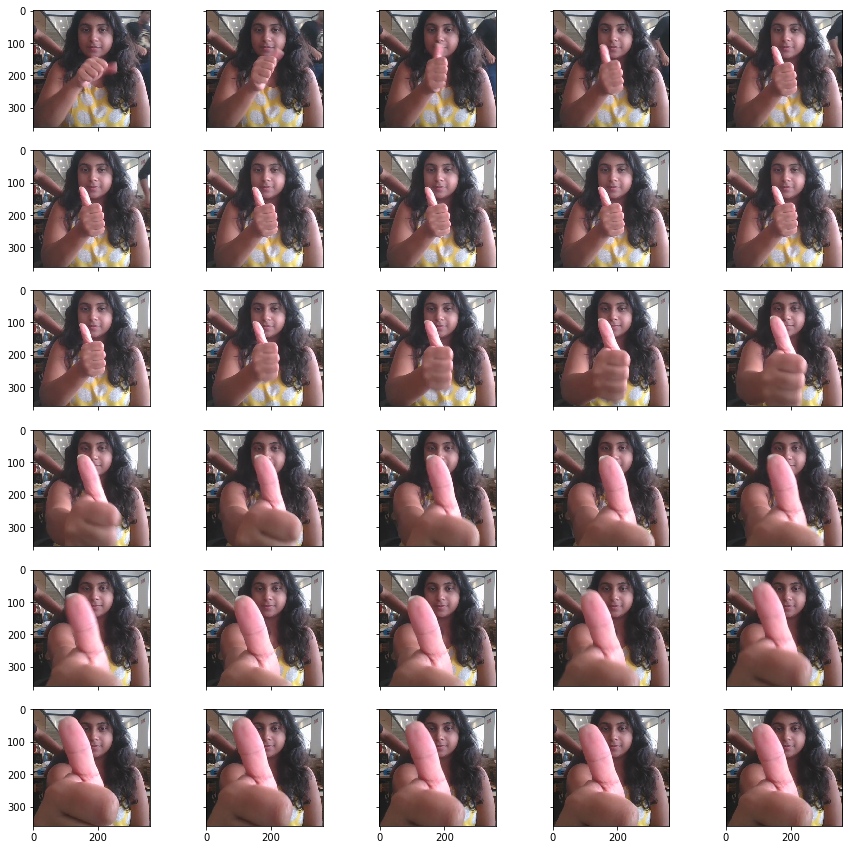

In [8]:
random_train_index = rn.randint(0, len(train_doc))

sequence_dir = train_doc[random_train_index].split(';')[0]

# list of all images in the folder
image_names = os.listdir('data/train/' + sequence_dir)

images = []
for name in image_names:
    img = cv2.imread('data/train/' + sequence_dir + '/' + name)
    images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

print('shape of an image in the selected sequence : {0}'.format(images[0].shape))    
    
plot_image(images)

### 2. Image Preprocessor
***

In [9]:
class ImagePreprocessor:
    def __init__(self,
                 height=240,
                 width=240,
                 channel=3,
                 affine=False,
                 crop=False,
                 edge=False,
                 normalize=False,
                 resize=False,
                 smoothing=False):
        self.__height = height
        self.__width = width
        self.__channel = channel
        self._affine = affine
        self._crop = crop
        self._edge = edge
        self._normalize = normalize
        self._resize = resize
        self._smoothing = smoothing

    def process_image(self, orig_image):
        pr_image = orig_image

        if self._crop:
            pr_image = self.__crop(pr_image)

        if self._resize:
            pr_image = self.__resize(pr_image)

        if self._normalize:
            pr_image = self.__normalize(pr_image)

        if self._smoothing:
            pr_image = self.__smoothing(pr_image)

        return pr_image

    def __crop(self, image):
        i_shape = image.shape
        return image[20:i_shape[0], 0:i_shape[1]]

    def __normalize(self, image):
        n_image = np.zeros((self.__height, self.__width, self.__channel))
        n_image = cv2.normalize(image, n_image, 0, 255, cv2.NORM_MINMAX)

        return n_image

    def __resize(self, image):
        return cv2.resize(image, (self.__height, self.__width),
                          interpolation=cv2.INTER_AREA)

    def __smoothing(self, image):
        return cv2.GaussianBlur(image, (5, 5), cv2.BORDER_DEFAULT)

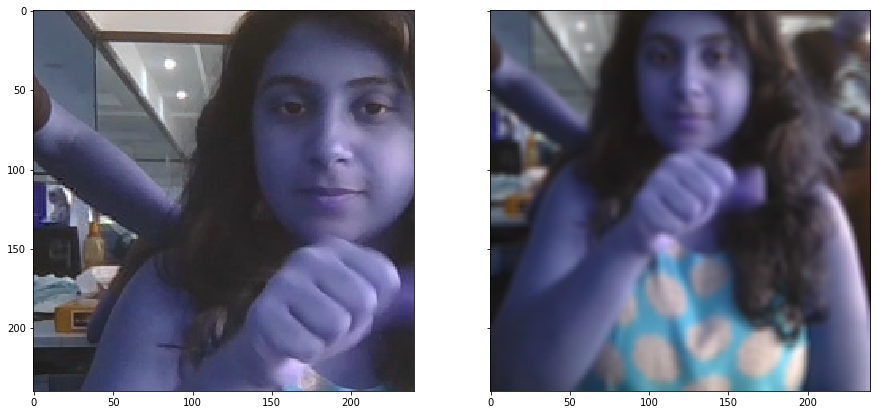

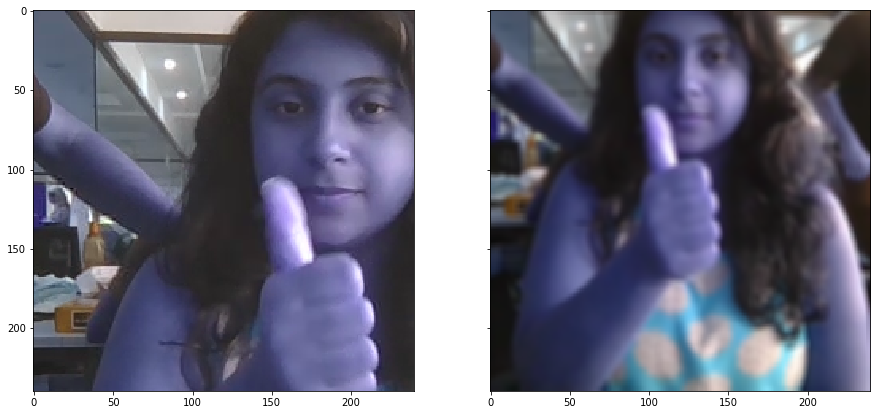

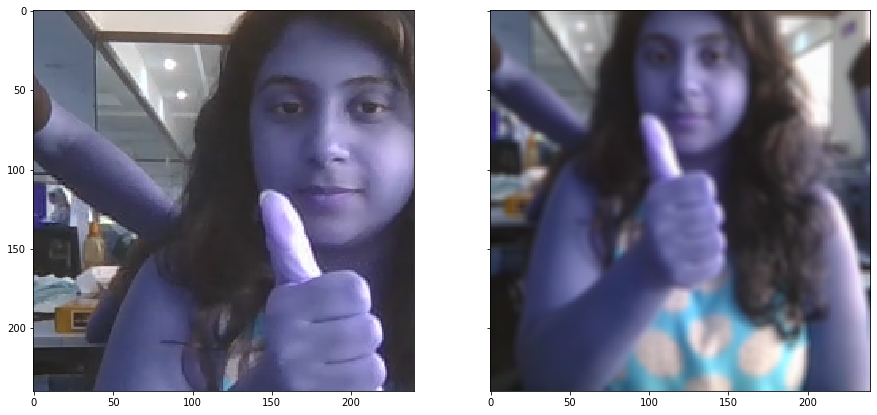

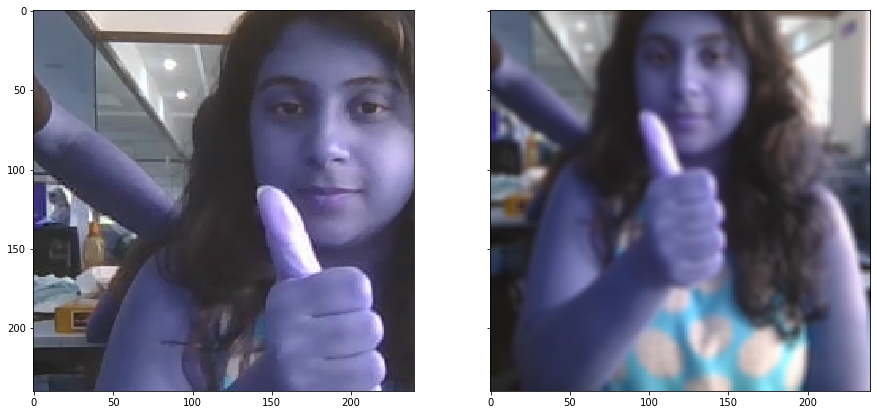

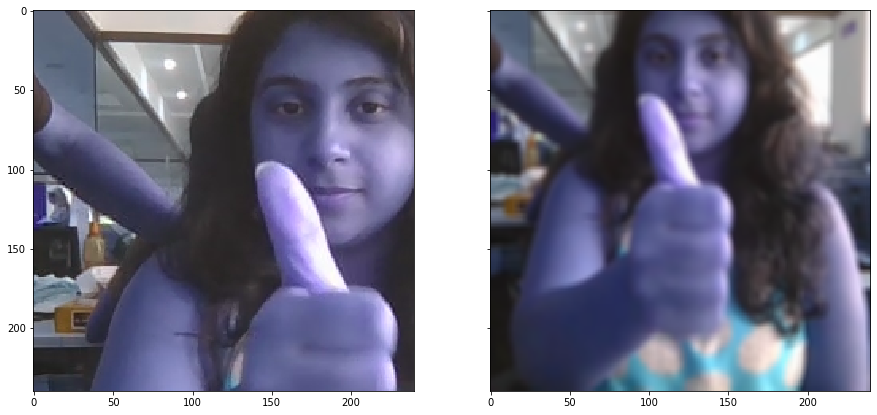

In [10]:
imagePreprocess = ImagePreprocessor(crop=True, normalize=True, resize=True, smoothing=True)

for name in image_names[0:15:3]:
    img = cv2.imread('data/train/' + sequence_dir + '/' + name)
    pr_image = imagePreprocess.process_image(orig_image=img)
    plot_image([img, pr_image])

### 3. Data Generator
***

In [11]:
def generator(source_path, folder_list, batch_size):
    print('Source path = ', source_path, '; batch size =', batch_size)

    img_idx = [x for x in range(0, 31, 3)]

    imagePreprocess = ImagePreprocessor(crop=True,
                                        normalize=True,
                                        resize=True,
                                        smoothing=True)

    while True:
        # shuffle the array of video sequences prior to creating individual batches
        t = np.random.permutation(folder_list)

        num_batches = 10

        for batch in range(num_batches):
            # x is the number of images you use for each video,
            # (y,z) is the final size of the input images
            # 3 is the number of channels RGB
            batch_data = np.zeros((batch_size, x, y, z, 3))

            # batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                # read all the images in the folder
                imgs = os.listdir(source_path + '/' +
                                  t[folder +
                                    (batch * batch_size)].split(';')[0])

                # iterate iver the frames/images of a folder to read them in
                for idx, item in enumerate(img_idx):
                    image = cv2.imread(
                        source_path + '/' +
                        t[folder +
                          (batch * batch_size)].strip().split(';')[0] + '/' +
                        imgs[item])

                    pr_image = imagePreprocess.process_image(orig_image=image)

                    batch_data[folder, idx, :, :, 0] = pr_image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = pr_image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = pr_image[:, :, 2]

                batch_labels[folder,
                             int(t[folder +
                                   (batch *
                                    batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            print("Batch: ", num_batches + 1, "Index:", batch_size)

            batch_size = len(folder_list) - (batch_size * num_batches)
            batch_data = np.zeros((batch_size, x, y, z, nb_channel))
            batch_labels = np.zeros((batch_size, 5))

            for folder in range(batch_size):
                imgs = os.listdir(source_path + '/' +
                                  t[folder +
                                    (batch * batch_size)].split(';')[0])
                for idx, item in enumerate(img_idx):
                    image = cv.imread(
                        source_path + '/' +
                        t[folder +
                          (batch * batch_size)].strip().split(';')[0] + '/' +
                        imgs[item]).astype(np.float32)

                    pr_image = imagePreprocess.process_image(orig_image=image)

                    batch_data[folder, idx, :, :, 0] = pr_image[:, :, 0]
                    batch_data[folder, idx, :, :, 1] = pr_image[:, :, 1]
                    batch_data[folder, idx, :, :, 2] = pr_image[:, :, 2]

                batch_labels[folder,
                             int(t[folder +
                                   (batch *
                                    batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels